<a href="https://colab.research.google.com/github/stanislawkubik/PCA-project-24/blob/main/PCA-rates-project-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries, downloading and cleaning data

In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas_datareader.data as web

import datetime
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import seaborn as sns

from scipy.optimize import minimize
import statsmodels.stats.diagnostic as smd
import statsmodels.api as sm

            DGS1MO  DGS3MO  DGS6MO  DGS1  DGS2  DGS3  DGS5  DGS7  DGS10  \
DATE                                                                      
2000-01-03     NaN    5.48    5.81  6.09  6.38  6.42  6.50  6.65   6.58   
2000-01-04     NaN    5.43    5.75  6.00  6.30  6.34  6.40  6.56   6.49   
2000-01-05     NaN    5.44    5.74  6.05  6.38  6.43  6.51  6.68   6.62   
2000-01-06     NaN    5.41    5.69  6.03  6.35  6.39  6.46  6.63   6.57   
2000-01-07     NaN    5.38    5.66  6.00  6.31  6.35  6.42  6.58   6.52   

            DGS20  DGS30  
DATE                      
2000-01-03   6.94   6.61  
2000-01-04   6.84   6.53  
2000-01-05   6.95   6.64  
2000-01-06   6.86   6.58  
2000-01-07   6.82   6.55  


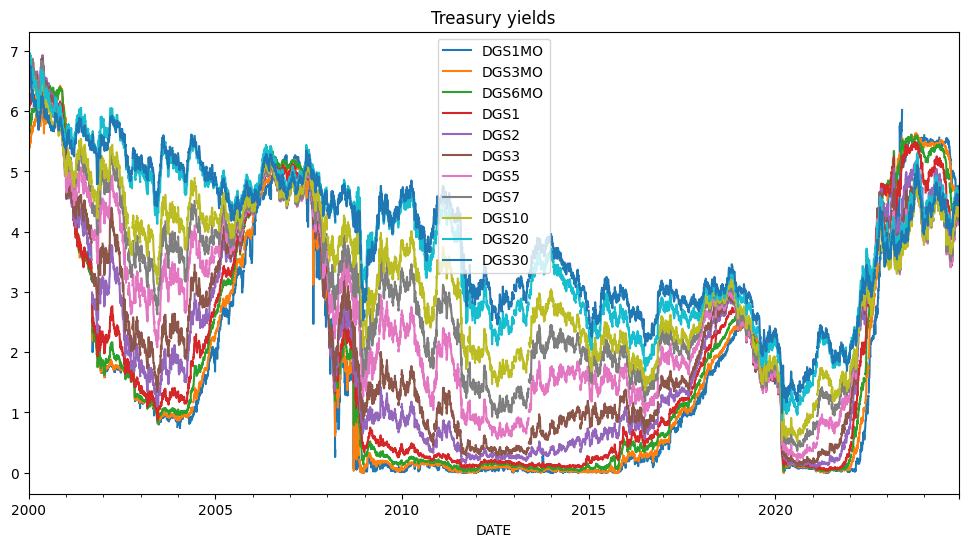

In [2]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2024, 12, 1)

maturities = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
tickers = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
bonds = web.DataReader(tickers, 'fred', start, end)



print(bonds.head())
bonds.plot(figsize=(12,6), title='Treasury yields')
plt.show()

In [3]:
names = ['WTI', 'SP500', 'VIX', 'IG Spread', 'HY Spread', '10y breakevens', '5y breakevens','ON RRP']
other_tx = ['DCOILWTICO', 'SP500', 'VIXCLS', 'AAA10Y', 'BAMLH0A0HYM2', 'T10YIE', 'T5YIE','RRPONTSYD']
other = web.DataReader(other_tx, 'fred', start, end)

In [4]:
bonds_clean = bonds.dropna()
print(bonds_clean.head())
print(bonds_clean.shape)

            DGS1MO  DGS3MO  DGS6MO  DGS1  DGS2  DGS3  DGS5  DGS7  DGS10  \
DATE                                                                      
2001-07-31    3.67    3.54    3.47  3.53  3.79  4.06  4.57  4.86   5.07   
2001-08-01    3.65    3.53    3.47  3.56  3.83  4.09  4.62  4.90   5.11   
2001-08-02    3.65    3.53    3.46  3.57  3.89  4.17  4.69  4.97   5.17   
2001-08-03    3.63    3.52    3.47  3.57  3.91  4.22  4.72  4.99   5.20   
2001-08-06    3.62    3.52    3.47  3.56  3.88  4.17  4.71  4.99   5.19   

            DGS20  DGS30  
DATE                      
2001-07-31   5.61   5.51  
2001-08-01   5.63   5.53  
2001-08-02   5.68   5.57  
2001-08-03   5.70   5.59  
2001-08-06   5.70   5.59  
(5836, 11)


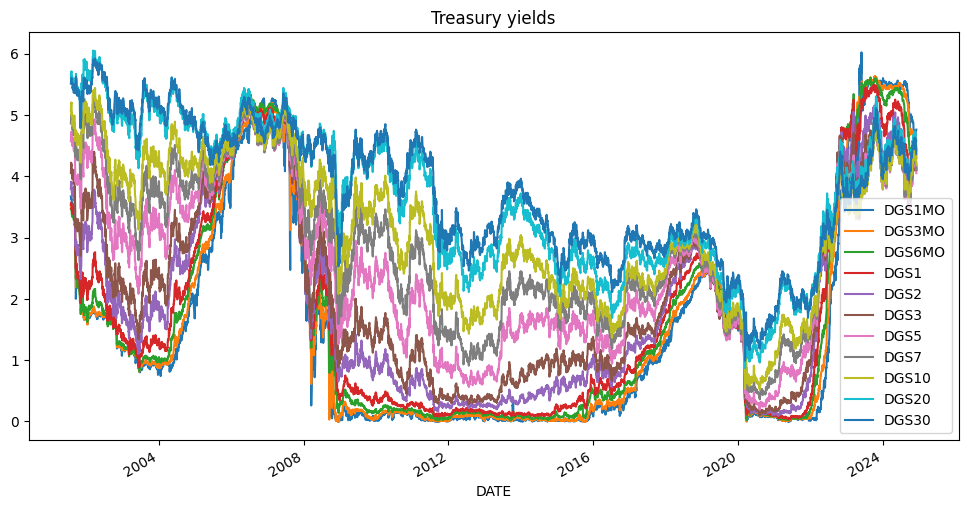

In [5]:
bonds_clean_plot = bonds_clean.plot(figsize=(12,6), title='Treasury yields')
plt.show()

In [6]:
bonds_clean1 = bonds_clean.loc['2001-01-01':'2007-07-08'] # start to gfc
bonds_clean2 = bonds_clean.loc['2007-07-09':'2017-12-31'] # gfc to 2018
bonds_clean3 = bonds_clean.loc['2018-01-01':'2024-12-31'] # 2018 to now
bonds_clean4 = bonds_clean.loc['2022-03-01':'2024-12-31'] #2022-24 tightening
bonds_clean5 = bonds_clean.loc['2008-12-01':'2015-11-30'] #zirp pre covid
bonds_clean6 = bonds_clean.loc['2020-03-01':'2022-03-01'] #zirp covid
bonds_clean7 = bonds_clean.loc['2015-12-01':'2020-02-29'] #2015-2020 cycle

# PCA on the entire dataset

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(bonds_clean)
pca = PCA(n_components=5)
p_c = pca.fit_transform(X)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
eigenvalues_scaled = pca.explained_variance_ratio_
print(eigenvalues_scaled)

cum_explained_variance = np.cumsum(eigenvalues_scaled)


for i in range(len(eigenvalues_scaled)):
    print(
        f"Explained variance for the first {i+1} PCs: "
        f"{cum_explained_variance[i]:.5f}"
    )

[8.39834415e-01 1.46871930e-01 1.08724044e-02 1.33630522e-03
 4.78951844e-04]
Explained variance for the first 1 PCs: 0.83983
Explained variance for the first 2 PCs: 0.98671
Explained variance for the first 3 PCs: 0.99758
Explained variance for the first 4 PCs: 0.99892
Explained variance for the first 5 PCs: 0.99939


We find that first 3 PCs explain more than 99.7% of the variance. Therefore, we can treat other PCs as residuals in our model

[0.83983442 0.14687193 0.0108724 ]
Explained variance for the first 1 PCs: 0.83983
Explained variance for the first 2 PCs: 0.98671
Explained variance for the first 3 PCs: 0.99758


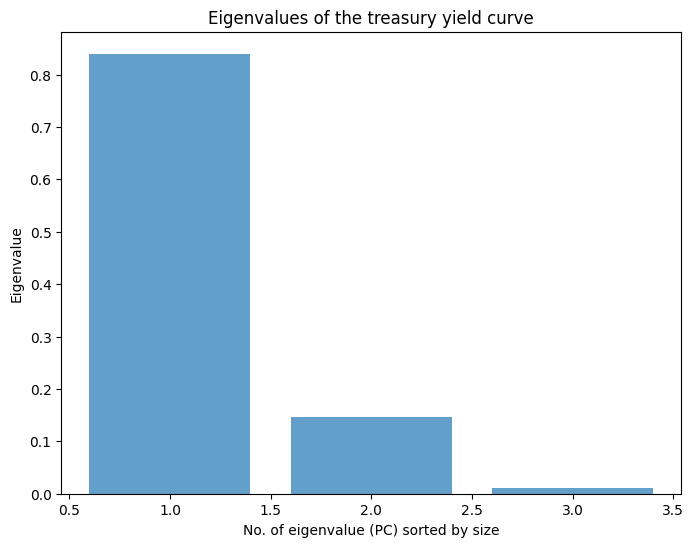

In [8]:
pca_x = PCA(n_components=3)
p_cx = pca_x.fit_transform(X)

eigenvaluesx = pca_x.explained_variance_
eigenvectorsx = pca_x.components_
eigenvalues_scaledx = pca_x.explained_variance_ratio_
print(eigenvalues_scaledx)

cum_explained_variance = np.cumsum(eigenvalues_scaledx)


for i in range(len(eigenvalues_scaledx)):
    print(
        f"Explained variance for the first {i+1} PCs: "
        f"{cum_explained_variance[i]:.5f}"
    )

pcax_df = pd.DataFrame(
    data=p_cx,
    columns = ['PC1', 'PC2', 'PC3']
)
pcax_df.index = bonds_clean.index

plt.figure('Eigenvalues', figsize=(8, 6))
plt.bar(range(1,4), eigenvalues_scaledx, alpha=0.7, label='Eigenvalues scaled to sum of 1')
plt.xlabel('No. of eigenvalue (PC) sorted by size')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the treasury yield curve')
plt.show()

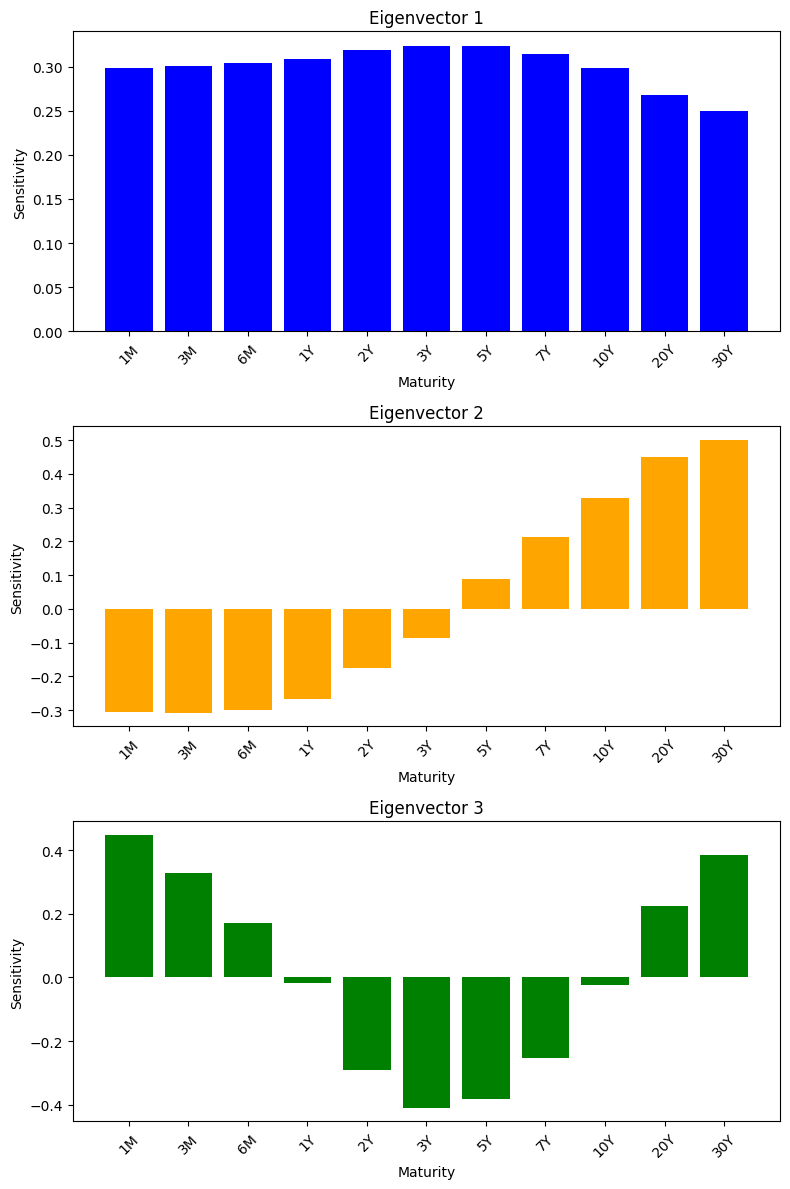

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes = axes.flatten()
colors = ['blue','orange','green','red']
for i in range(3):
  ax = axes[i]
  ax.bar(maturities, eigenvectorsx[i], color=colors[i])
  ax.set_title(f'Eigenvector {i+1}')
  ax.set_xlabel('Maturity')
  ax.set_ylabel('Sensitivity')
  ax.set_xticks(range(len(maturities)))
  ax.set_xticklabels(maturities, rotation=45)

plt.tight_layout()
plt.show()

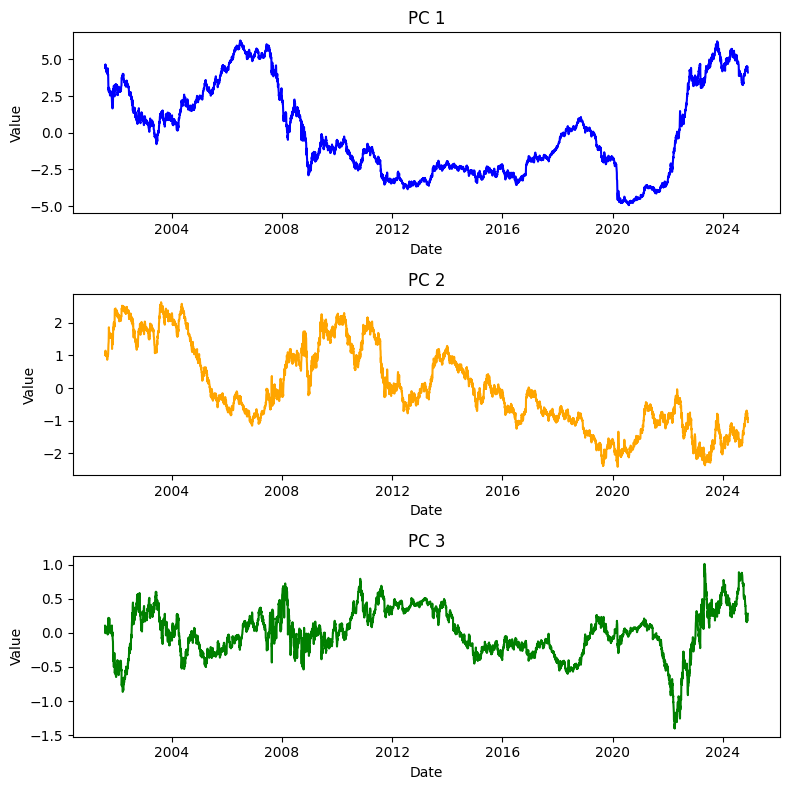

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
axes = axes.flatten()
colors = ['blue','orange','green','red']

for i, pc in enumerate(pcax_df.columns):
  axes[i].plot(pcax_df.index, pcax_df[pc], color=colors[i])
  axes[i].set_title(f'PC {i+1}')
  axes[i].set_xlabel('Date')
  axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

# PCA 2001 - GFC

[0.71356097 0.26928142 0.01429758]
Explained variance for the first 1 PCs: 0.71356
Explained variance for the first 2 PCs: 0.98284
Explained variance for the first 3 PCs: 0.99714


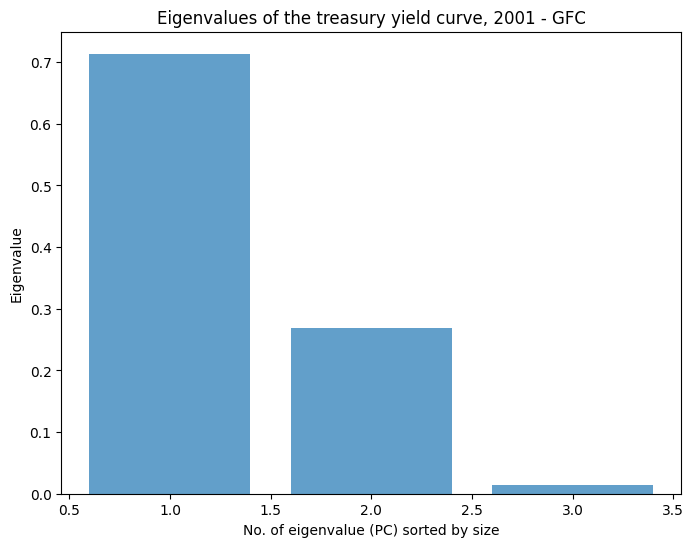

In [11]:
X1 = scaler.fit_transform(bonds_clean1)

pca1 = PCA(n_components=3)
p_c1 = pca1.fit_transform(X1)

eigenvalues1 = pca1.explained_variance_
eigenvectors1 = pca1.components_
eigenvalues_scaled1 = pca1.explained_variance_ratio_
print(eigenvalues_scaled1)

cum_explained_variance1 = np.cumsum(eigenvalues_scaled1)


for i in range(len(eigenvalues_scaled1)):
    print(
        f"Explained variance for the first {i+1} PCs: "
        f"{cum_explained_variance1[i]:.5f}"
    )
pca1_df = pd.DataFrame(
    data=p_c1,
    columns = ['PC1', 'PC2', 'PC3']
)
pca1_df.index = bonds_clean1.index

plt.figure('Eigenvalues 2001 - GFC', figsize=(8, 6))
plt.bar(range(1,4), eigenvalues_scaled1, alpha=0.7, label='Eigenvalues scaled to sum of 1')
plt.xlabel('No. of eigenvalue (PC) sorted by size')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the treasury yield curve, 2001 - GFC')
plt.show()

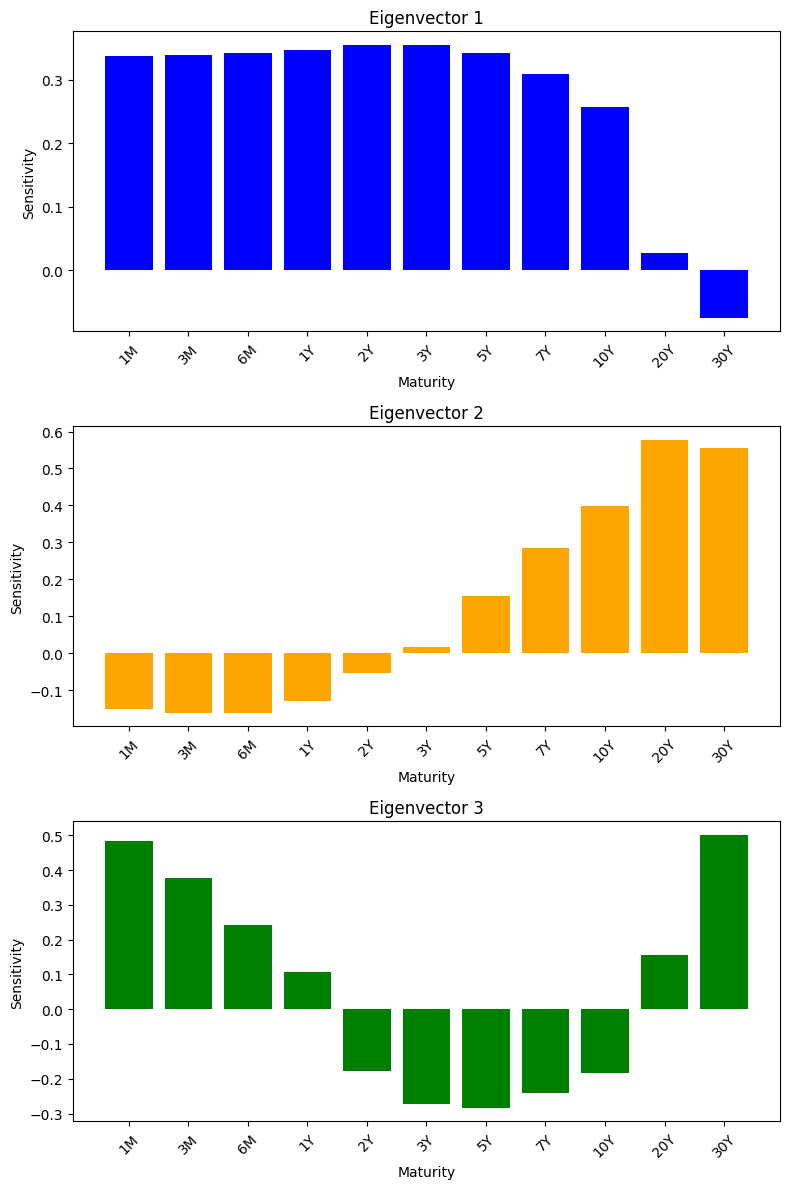

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes = axes.flatten()
colors = ['blue','orange','green','red']
for i in range(3):
  ax = axes[i]
  ax.bar(maturities, eigenvectors1[i], color=colors[i])
  ax.set_title(f'Eigenvector {i+1}')
  ax.set_xlabel('Maturity')
  ax.set_ylabel('Sensitivity')
  ax.set_xticks(range(len(maturities)))
  ax.set_xticklabels(maturities, rotation=45)

plt.tight_layout()
plt.show()

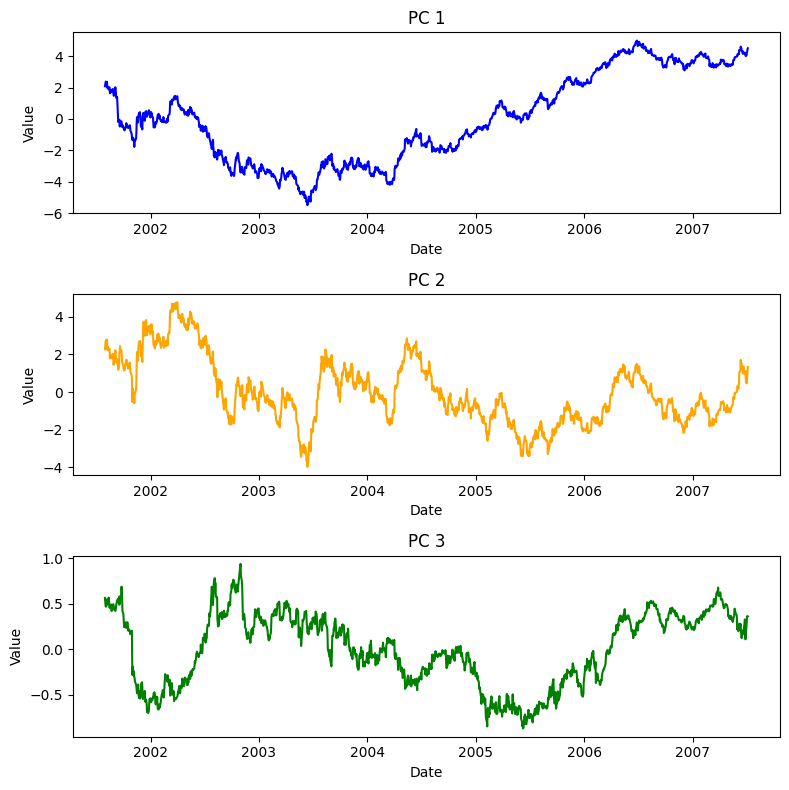

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
axes = axes.flatten()
colors = ['blue','orange','green','red']

for i, pc in enumerate(pca1_df.columns):
  axes[i].plot(pca1_df.index, pca1_df[pc], color=colors[i])
  axes[i].set_title(f'PC {i+1}')
  axes[i].set_xlabel('Date')
  axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

# PCA 2008 - 2015 ZIRP

[0.67555015 0.18574383 0.10083274 0.02475154]
Explained variance for the first 1 PCs: 0.67555
Explained variance for the first 2 PCs: 0.86129
Explained variance for the first 3 PCs: 0.96213
Explained variance for the first 4 PCs: 0.98688


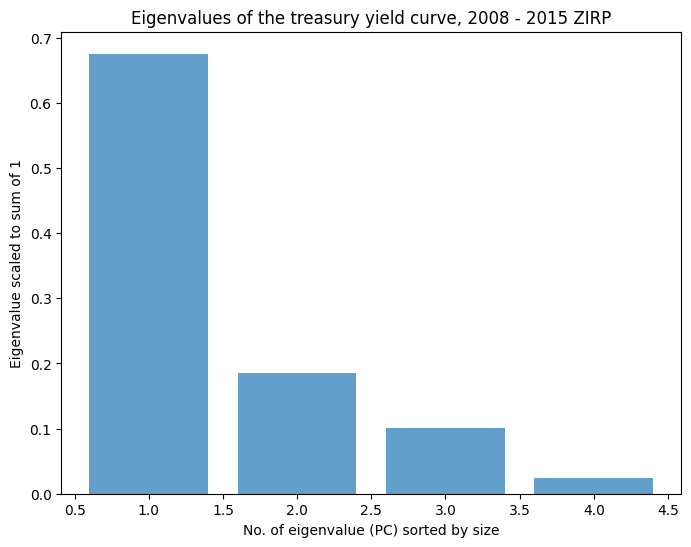

In [30]:
X5 = scaler.fit_transform(bonds_clean5)

pca5 = PCA(n_components=4)
p_c5 = pca5.fit_transform(X5)

eigenvalues5 = pca5.explained_variance_
eigenvectors5 = pca5.components_
eigenvalues_scaled5 = pca5.explained_variance_ratio_
print(eigenvalues_scaled5)

cum_explained_variance5 = np.cumsum(eigenvalues_scaled5)


for i in range(len(eigenvalues_scaled5)):
    print(
        f"Explained variance for the first {i+1} PCs: "
        f"{cum_explained_variance5[i]:.5f}"
    )
pca5_df = pd.DataFrame(
    data=p_c5,
    columns = ['PC1', 'PC2', 'PC3', 'PC4']
)
pca5_df.index = bonds_clean5.index

plt.figure('Eigenvalues 2008 - 2015 ZIRP', figsize=(8, 6))
plt.bar(range(1,5), eigenvalues_scaled5, alpha=0.7, label='Eigenvalues scaled to sum of 1')
plt.xlabel('No. of eigenvalue (PC) sorted by size')
plt.ylabel('Eigenvalue scaled to sum of 1')
plt.title('Eigenvalues of the treasury yield curve, 2008 - 2015 ZIRP')
plt.show()

For ZIRP eras, we may include 4 Principal components. Intuitively, it makes sense that first 3 PCs explain less variance, as during that time there was significantly less volatility connected with the level (PC1) of the yields

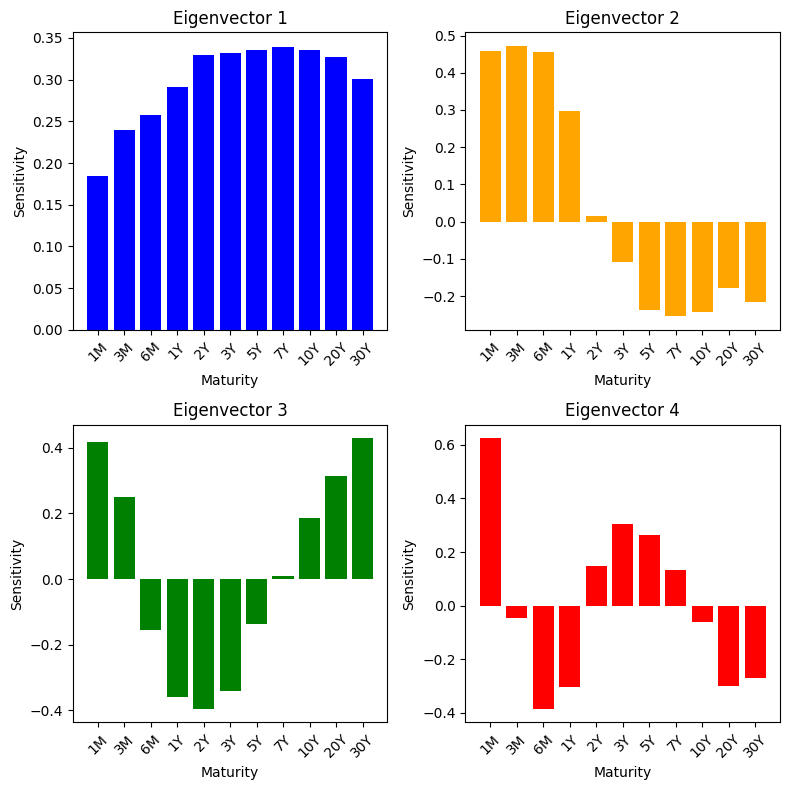

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
colors = ['blue','orange','green','red']
for i in range(4):
  ax = axes[i]
  ax.bar(maturities, eigenvectors5[i], color=colors[i])
  ax.set_title(f'Eigenvector {i+1}')
  ax.set_xlabel('Maturity')
  ax.set_ylabel('Sensitivity')
  ax.set_xticks(range(len(maturities)))
  ax.set_xticklabels(maturities, rotation=45)

plt.tight_layout()
plt.show()

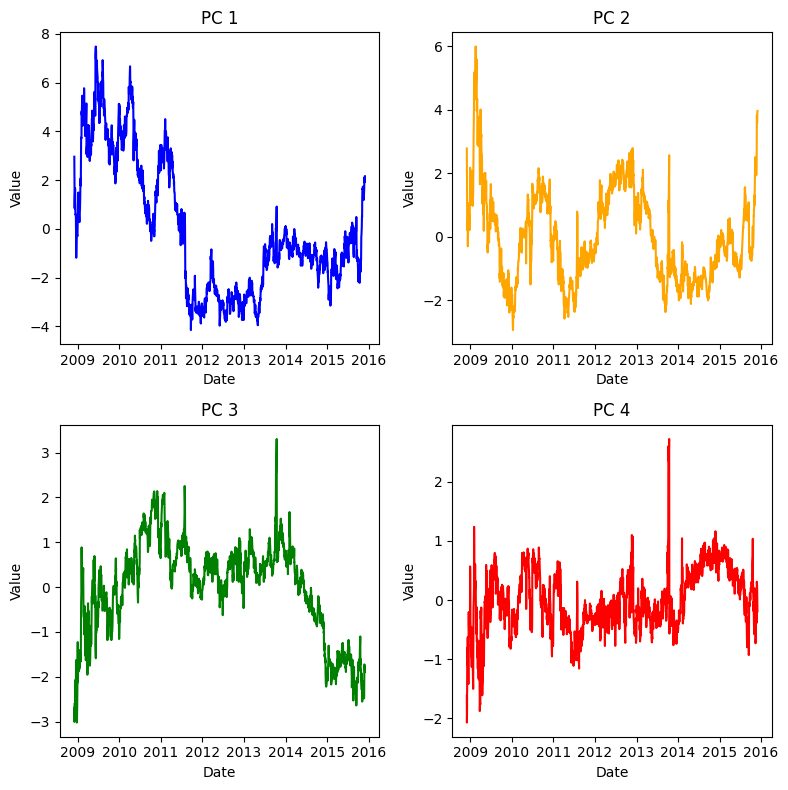

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
colors = ['blue','orange','green','red']

for i, pc in enumerate(pca5_df.columns):
  axes[i].plot(pca5_df.index, pca5_df[pc], color=colors[i])
  axes[i].set_title(f'PC {i+1}')
  axes[i].set_xlabel('Date')
  axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

# PCA 2015 - 2020 Tightening

[0.80328604 0.18575338 0.00909337]
Explained variance for the first 1 PCs: 0.80329
Explained variance for the first 2 PCs: 0.98904
Explained variance for the first 3 PCs: 0.99813


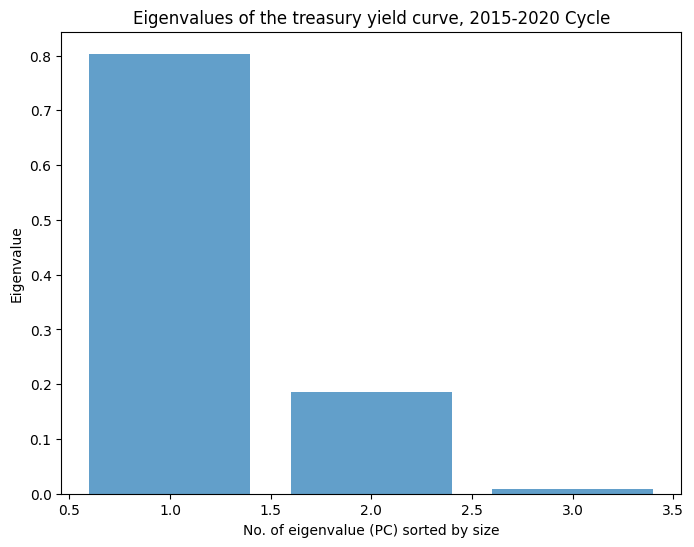

In [17]:
X7 = scaler.fit_transform(bonds_clean7)

pca7 = PCA(n_components=3)
p_c7 = pca7.fit_transform(X7)

eigenvalues7 = pca7.explained_variance_
eigenvectors7 = pca7.components_
eigenvalues_scaled7 = pca7.explained_variance_ratio_
print(eigenvalues_scaled7)

cum_explained_variance7 = np.cumsum(eigenvalues_scaled7)


for i in range(len(eigenvalues_scaled7)):
    print(
        f"Explained variance for the first {i+1} PCs: "
        f"{cum_explained_variance7[i]:.5f}"
    )

pca7_df = pd.DataFrame(
    data=p_c7,
    columns = ['PC1', 'PC2', 'PC3']
)

pca7_df.index = bonds_clean7.index

plt.figure('Eigenvalues 2015-2020 Cycle', figsize=(8, 6))
plt.bar(range(1,4), eigenvalues_scaled7, alpha=0.7, label='Eigenvalues scaled to sum of 1')
plt.xlabel('No. of eigenvalue (PC) sorted by size')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the treasury yield curve, 2015-2020 Cycle')
plt.show()

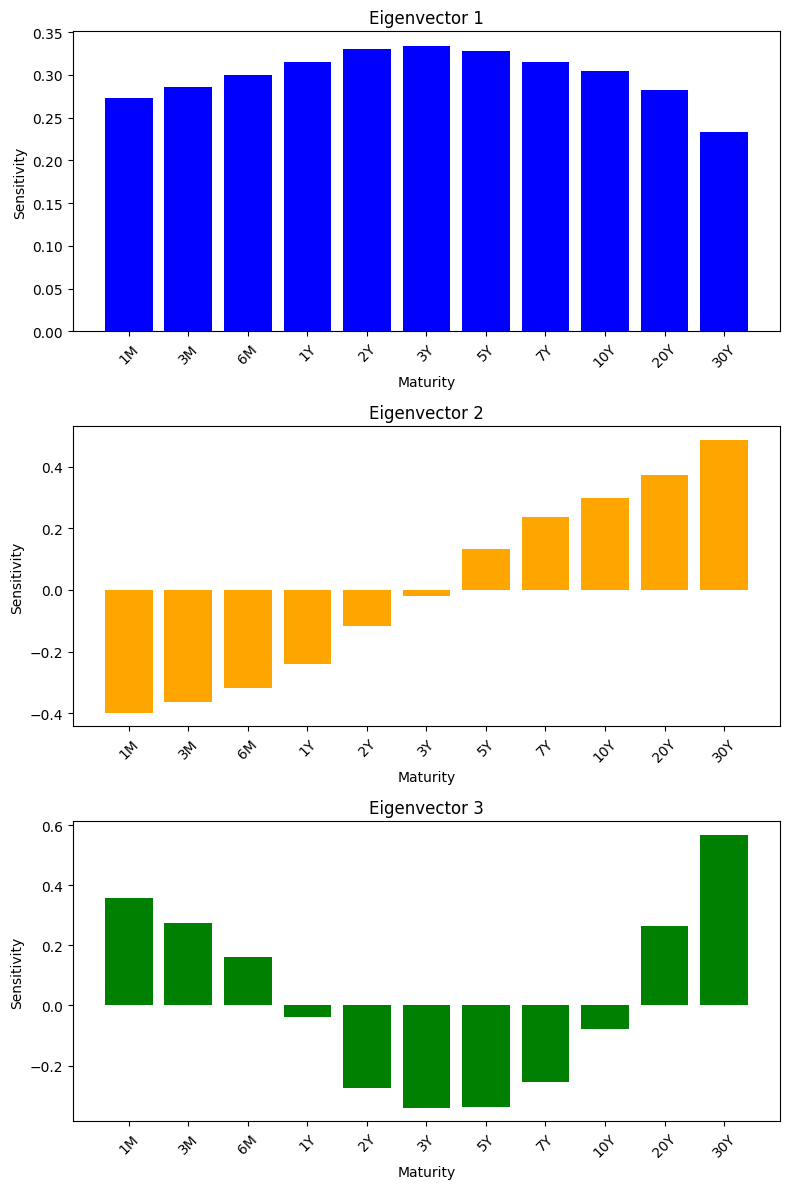

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes = axes.flatten()
colors = ['blue','orange','green','red']
for i in range(3):
  ax = axes[i]
  ax.bar(maturities, eigenvectors7[i], color=colors[i])
  ax.set_title(f'Eigenvector {i+1}')
  ax.set_xlabel('Maturity')
  ax.set_ylabel('Sensitivity')
  ax.set_xticks(range(len(maturities)))
  ax.set_xticklabels(maturities, rotation=45)

plt.tight_layout()
plt.show()

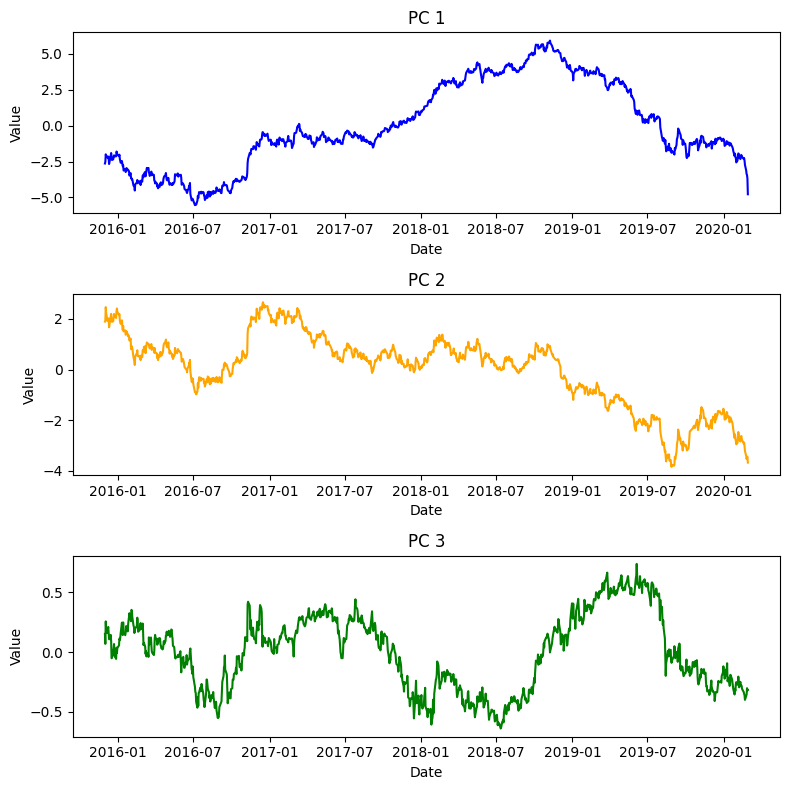

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
axes = axes.flatten()
colors = ['blue','orange','green','red']

for i, pc in enumerate(pca7_df.columns):
  axes[i].plot(pca7_df.index, pca7_df[pc], color=colors[i])
  axes[i].set_title(f'PC {i+1}')
  axes[i].set_xlabel('Date')
  axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

# PCA 2020 - 2022 ZIRP

[0.5768574  0.32195179 0.07549    0.02230626]
Explained variance for the first 1 PCs: 0.57686
Explained variance for the first 2 PCs: 0.89881
Explained variance for the first 3 PCs: 0.97430
Explained variance for the first 4 PCs: 0.99661


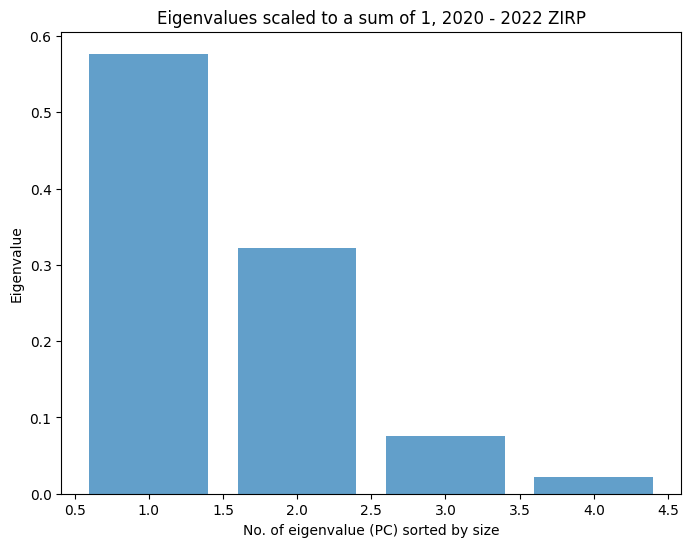

In [31]:
X6 = scaler.fit_transform(bonds_clean6)

pca6 = PCA(n_components=4)
p_c6 = pca6.fit_transform(X6)

eigenvalues6 = pca6.explained_variance_
eigenvectors6 = pca6.components_
eigenvalues_scaled6 = pca6.explained_variance_ratio_
print(eigenvalues_scaled6)

cum_explained_variance6 = np.cumsum(eigenvalues_scaled6)


for i in range(len(eigenvalues_scaled6)):
    print(
        f"Explained variance for the first {i+1} PCs: "
        f"{cum_explained_variance6[i]:.5f}"
    )

pca6_df = pd.DataFrame(
    data=p_c6,
    columns = ['PC1', 'PC2', 'PC3', 'PC4']
)

pca6_df.index = bonds_clean6.index

plt.figure('Eigenvalues 2020 - 2022 ZIRP', figsize=(8, 6))
plt.bar(range(1,5), eigenvalues_scaled6, alpha=0.7, label='Eigenvalues scaled to sum of 1')
plt.xlabel('No. of eigenvalue (PC) sorted by size')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues scaled to a sum of 1, 2020 - 2022 ZIRP')
plt.show()

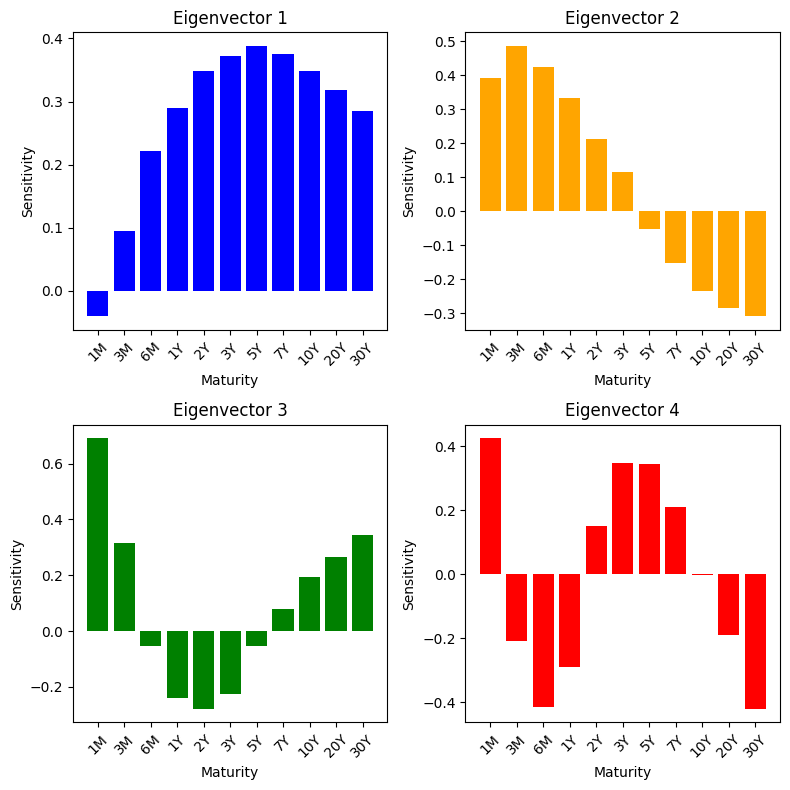

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
colors = ['blue','orange','green','red']
for i in range(4):
  ax = axes[i]
  ax.bar(maturities, eigenvectors6[i], color=colors[i])
  ax.set_title(f'Eigenvector {i+1}')
  ax.set_xlabel('Maturity')
  ax.set_ylabel('Sensitivity')
  ax.set_xticks(range(len(maturities)))
  ax.set_xticklabels(maturities, rotation=45)

plt.tight_layout()
plt.show()

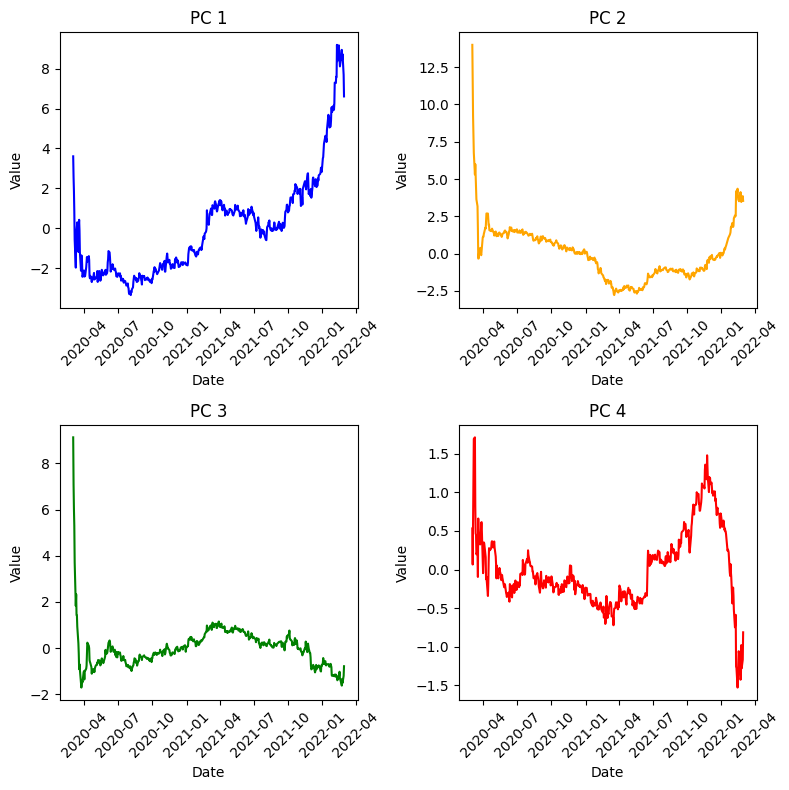

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
colors = ['blue','orange','green','red']

for i, pc in enumerate(pca6_df.columns):
  axes[i].plot(pca6_df.index, pca6_df[pc], color=colors[i])
  axes[i].set_title(f'PC {i+1}')
  axes[i].set_xlabel('Date')
  axes[i].set_ylabel('Value')
  axes[i].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

# PCA Current Cycle (2022 - 24)

[0.9230709  0.05225329 0.02213007]
Explained variance for the first 1 PCs: 0.92307
Explained variance for the first 2 PCs: 0.97532
Explained variance for the first 3 PCs: 0.99745


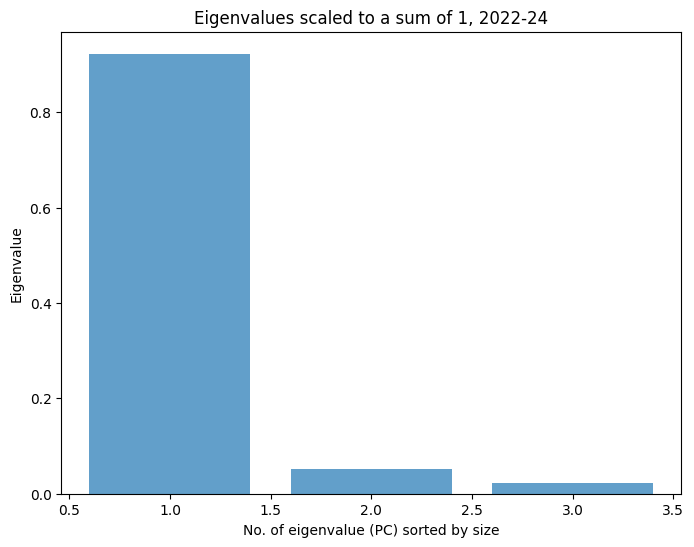

In [32]:
scaler = StandardScaler()
X4 = scaler.fit_transform(bonds_clean4)

pca4 = PCA(n_components=3)
p_c4 = pca4.fit_transform(X4)

eigenvalues4 = pca4.explained_variance_
eigenvectors4 = pca4.components_
eigenvalues_scaled4 = pca4.explained_variance_ratio_
print(eigenvalues_scaled4)

cum_explained_variance4 = np.cumsum(eigenvalues_scaled4)


for i in range(len(eigenvalues_scaled4)):
    print(
        f"Explained variance for the first {i+1} PCs: "
        f"{cum_explained_variance4[i]:.5f}"
    )

pca4_df = pd.DataFrame(
    data=p_c4,
    columns = ['PC1', 'PC2', 'PC3']
)
pca4_df.index = bonds_clean4.index

plt.figure('Eigenvalues 2001 - GFC', figsize=(8, 6))
plt.bar(range(1,4), eigenvalues_scaled4, alpha=0.7, label='Eigenvalues scaled to sum of 1')
plt.xlabel('No. of eigenvalue (PC) sorted by size')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues scaled to a sum of 1, 2022-24')
plt.show()

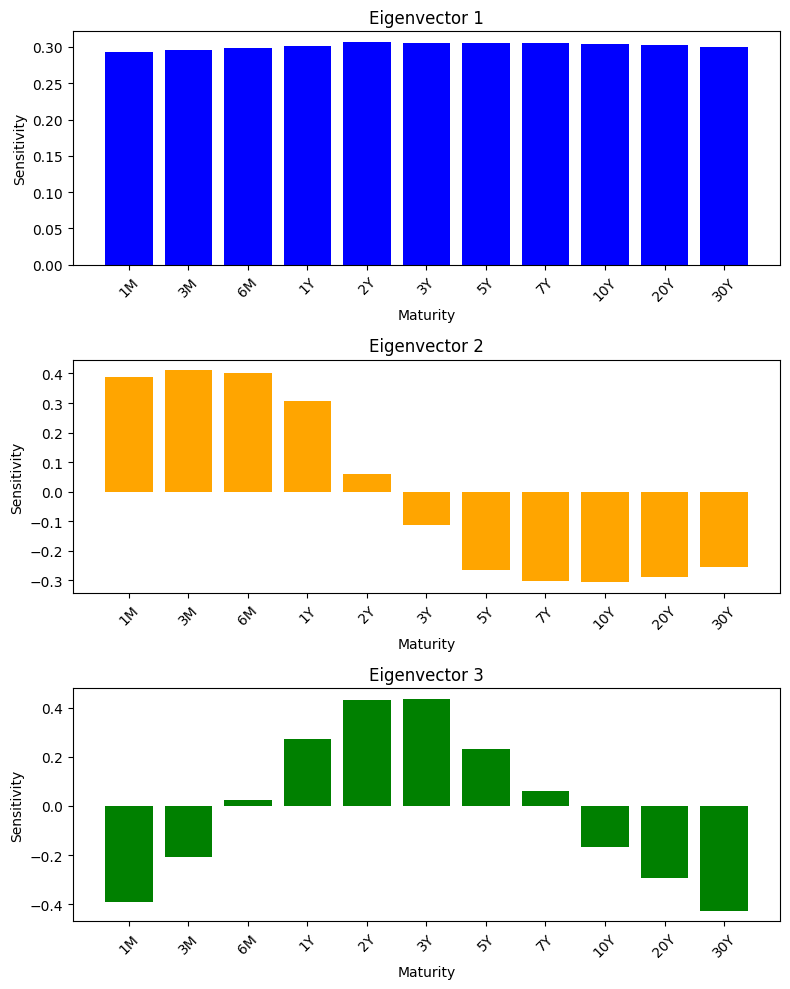

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
axes = axes.flatten()
colors = ['blue','orange','green','red']
for i in range(3):
  ax = axes[i]
  ax.bar(maturities, eigenvectors4[i], color=colors[i])
  ax.set_title(f'Eigenvector {i+1}')
  ax.set_xlabel('Maturity')
  ax.set_ylabel('Sensitivity')
  ax.set_xticks(range(len(maturities)))
  ax.set_xticklabels(maturities, rotation=45)

plt.tight_layout()
plt.show()

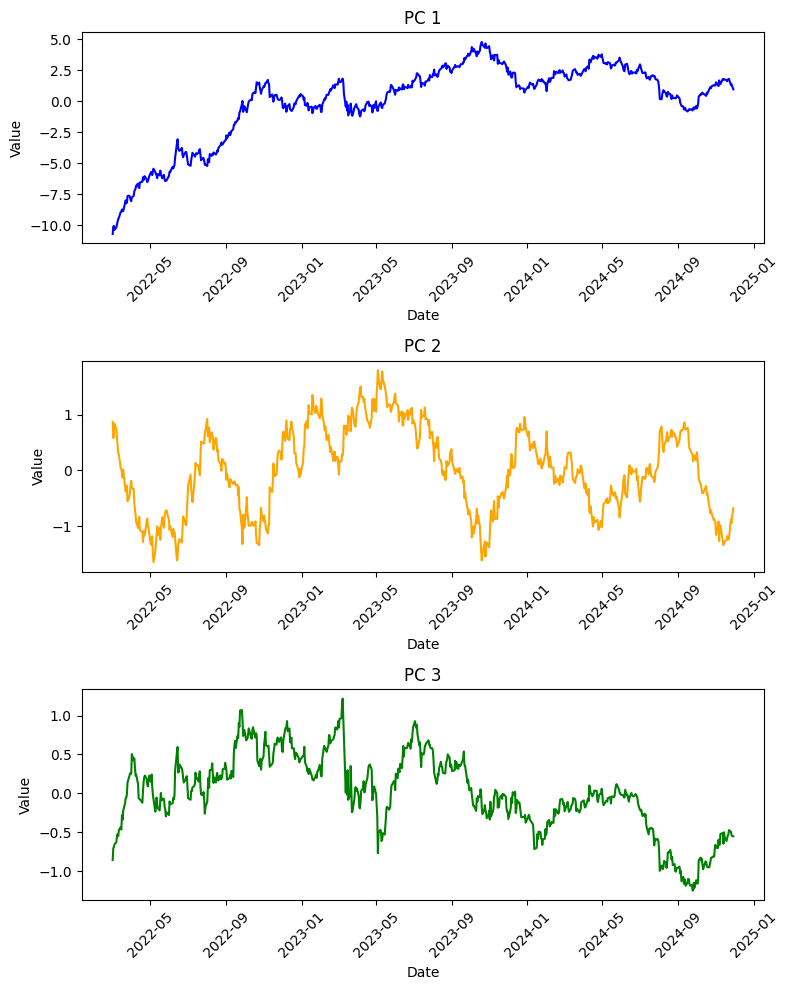

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
axes = axes.flatten()
colors = ['blue','orange','green','red']

for i, pc in enumerate(pca4_df.columns):
  ax = axes[i]
  ax.plot(pca4_df.index, pca4_df[pc], color=colors[i])
  ax.set_title(f'PC {i+1}')
  ax.set_xlabel('Date')
  ax.set_ylabel('Value')
  ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

# Further analysis of principal components

In this section, I further research the correlations between the PCs in the current cycle, and try to model PC 2 (slope) as a mean-reverting process.

Checking correlations

In [27]:
other4 = other.loc['2022-03-01':'2024-12-31'].dropna()

pca4_df_cols = pca4_df.columns
other4_cols = other4.columns

df_corr = pd.concat([pca4_df, other4], axis=1)
corr_matrix = df_corr.corr()
corr_matrix = corr_matrix.loc[pca4_df_cols, other4_cols]
corr_matrix.columns = names

print(corr_matrix)


          WTI     SP500       VIX  IG Spread  HY Spread  10y breakevens  \
PC1 -0.698429  0.365907 -0.675723  -0.804796  -0.353073       -0.667684   
PC2 -0.455493 -0.090836 -0.296353   0.014714   0.122322       -0.509818   
PC3  0.155112 -0.711999  0.214645  -0.072384   0.557195        0.190188   

     5y breakevens    ON RRP  
PC1      -0.770467 -0.452658  
PC2      -0.430802  0.220877  
PC3       0.194824  0.711564  


Modeling PC2 as mean-reverting

In [28]:
PC2 = pd.DataFrame()
PC2['PC2'] = pca4_df['PC2']
buckets = 10 #adjust
low, high = PC2['PC2'].min(), PC2['PC2'].max()
bucket_bounds = np.linspace(low, high, buckets+1)
bucket_mid = (bucket_bounds[:-1] + bucket_bounds[1:]) / 2
PC2['Bucket'] = pd.cut(PC2['PC2'], bins=bucket_bounds, labels=bucket_mid)
PC2['Bucket'] = PC2['Bucket'].astype(float)
PC2['Change'] = PC2['PC2'].diff().shift(-1)

bucket_summ = PC2.groupby('Bucket')['Change'].agg(
    Count='count',
    Mean='mean',
    Std='std'
)
print
print(bucket_summ)

           Count      Mean       Std
Bucket                              
-1.477304     19  0.107337  0.165770
-1.132237     73  0.026749  0.178901
-0.787170     80 -0.031079  0.149615
-0.442102     71 -0.000702  0.162924
-0.097035    120  0.003756  0.133044
 0.248032    103 -0.005000  0.144154
 0.593100     96  0.004720  0.145058
 0.938167     78 -0.013689  0.158992
 1.283234     37 -0.060338  0.114671
 1.628302     10 -0.028593  0.161362


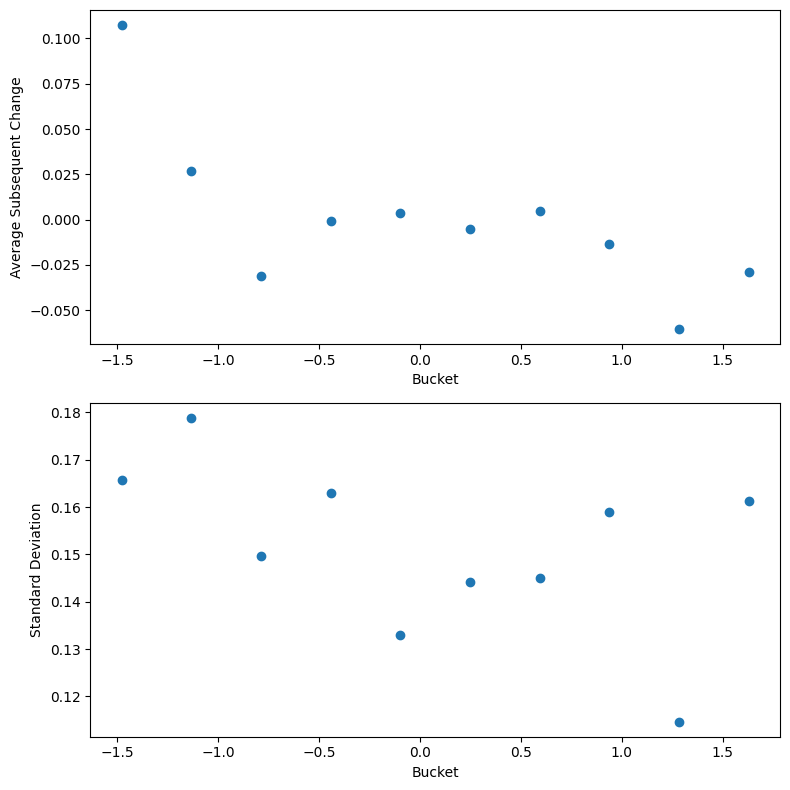

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(8,8))

axes[0].scatter(bucket_mid, bucket_summ['Mean'])
axes[0].set_xlabel('Bucket')
axes[0].set_ylabel('Average Subsequent Change')

axes[1].scatter(bucket_mid, bucket_summ['Std'])
axes[1].set_xlabel('Bucket')
axes[1].set_ylabel('Standard Deviation')

plt.tight_layout()
plt.show()


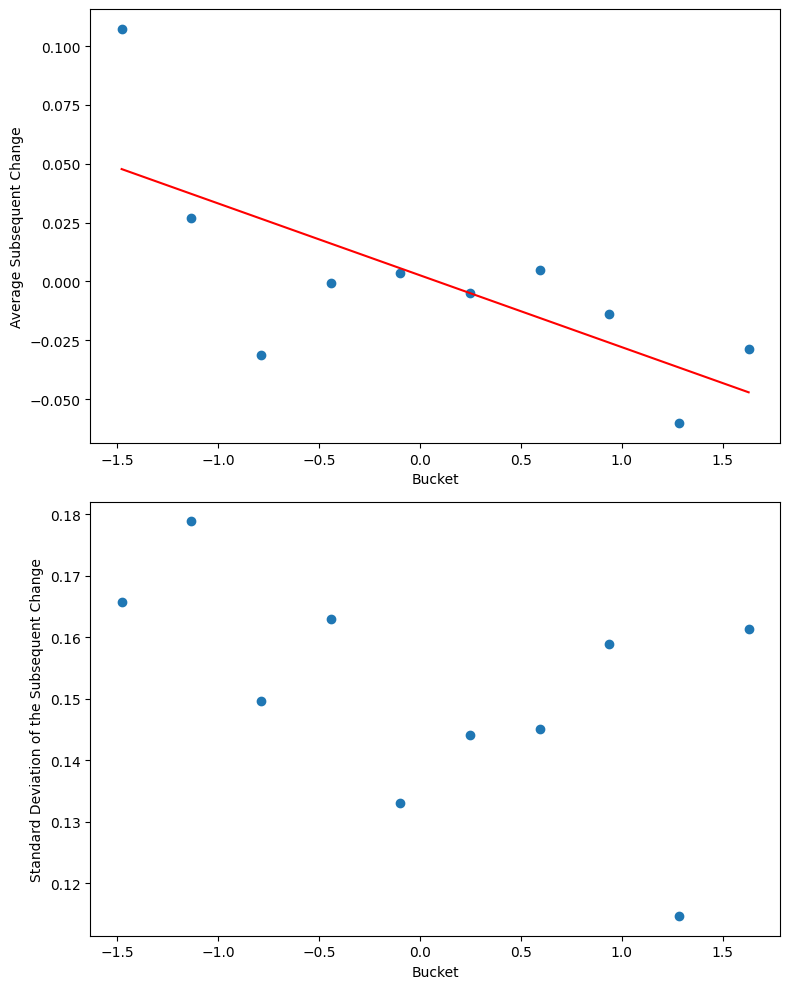

[-0.03053473  0.00262136]


In [ ]:
x = bucket_summ.index
y = bucket_summ['Mean']
degree = 1 #degree of the polynomial

coefficients = np.polyfit(x, y, deg=degree)
model = np.poly1d(coefficients)
x_fitted = np.linspace(min(x), max(x), 200)
y_fit = model(x_fitted)

ig, axes = plt.subplots(2, 1, figsize=(8,10))

axes[0].scatter(bucket_mid, bucket_summ['Mean'])
axes[0].set_xlabel('Bucket')
axes[0].set_ylabel('Average Subsequent Change')
axes[0].plot(x_fitted, y_fit, color='red')

axes[1].scatter(bucket_mid, bucket_summ['Std'])
axes[1].set_xlabel('Bucket')
axes[1].set_ylabel('Standard Deviation of the Subsequent Change')

plt.tight_layout()
plt.show()
print(coefficients)

